# MLflow TrackingとOptuna

実行処理の保存単位として、ネストしての保存が可能であることはすでに言及した。  
実験のアプローチとネストの設計は、実験を構成するうえでは非常に重要になる。

ネストが用いられる重要な例として、Optunaを実行するときの実行処理の保存を取り扱う。  
これまで用いてきたデータセット apple_data を用いて、Optuna + XGBoostの実験の記録を行っていく。

In [1]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

/home/user01/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 実験の定義

### トラッキングサーバURIの設定

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")

### apple_data の読み込み

In [3]:
df = pd.read_csv('apple_data.csv', parse_dates=[0])
df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,1996-12-02 23:45:11.240034,30.584727,1.831006,0,0,1.578387,1,1001.647352,1026.324266,0.755725,0.323086
1,1996-12-03 23:45:11.240032,15.465069,0.761303,0,0,1.965125,0,843.972638,1026.324266,0.913934,0.030371
2,1996-12-04 23:45:11.240031,10.786525,1.427338,0,0,1.497623,0,890.319248,868.942267,2.879262,0.354226
3,1996-12-05 23:45:11.240030,23.648154,3.737435,0,0,1.952936,0,811.206168,889.965021,0.826015,0.953000
4,1996-12-06 23:45:11.240029,13.861391,5.598549,0,0,2.059993,0,822.279469,835.253168,1.130145,0.953000
...,...,...,...,...,...,...,...,...,...,...,...
9995,2024-04-14 23:45:11.226286,23.358868,7.061220,1,0,1.556829,1,2566.432998,2676.279445,0.560507,0.889971
9996,2024-04-15 23:45:11.226284,14.859048,0.868655,0,0,1.632918,1,2032.827646,2590.543027,2.460766,0.884467
9997,2024-04-16 23:45:11.226283,17.941035,13.739986,0,0,0.827723,1,2167.417581,2031.943179,1.321922,0.884467
9998,2024-04-17 23:45:11.226281,14.533862,1.610512,0,0,0.589172,1,2099.505096,2166.533113,2.604095,0.812706


In [4]:
df.dtypes

date                       datetime64[ns]
average_temperature               float64
rainfall                          float64
weekend                             int64
holiday                             int64
price_per_kg                      float64
promo                               int64
demand                            float64
previous_days_demand              float64
competitor_price_per_kg           float64
marketing_intensity               float64
dtype: object

## 可視化

### 特徴量と目標変数の相関

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def plot_correlation_with_demand(df, save_path=None):
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)

    return fig

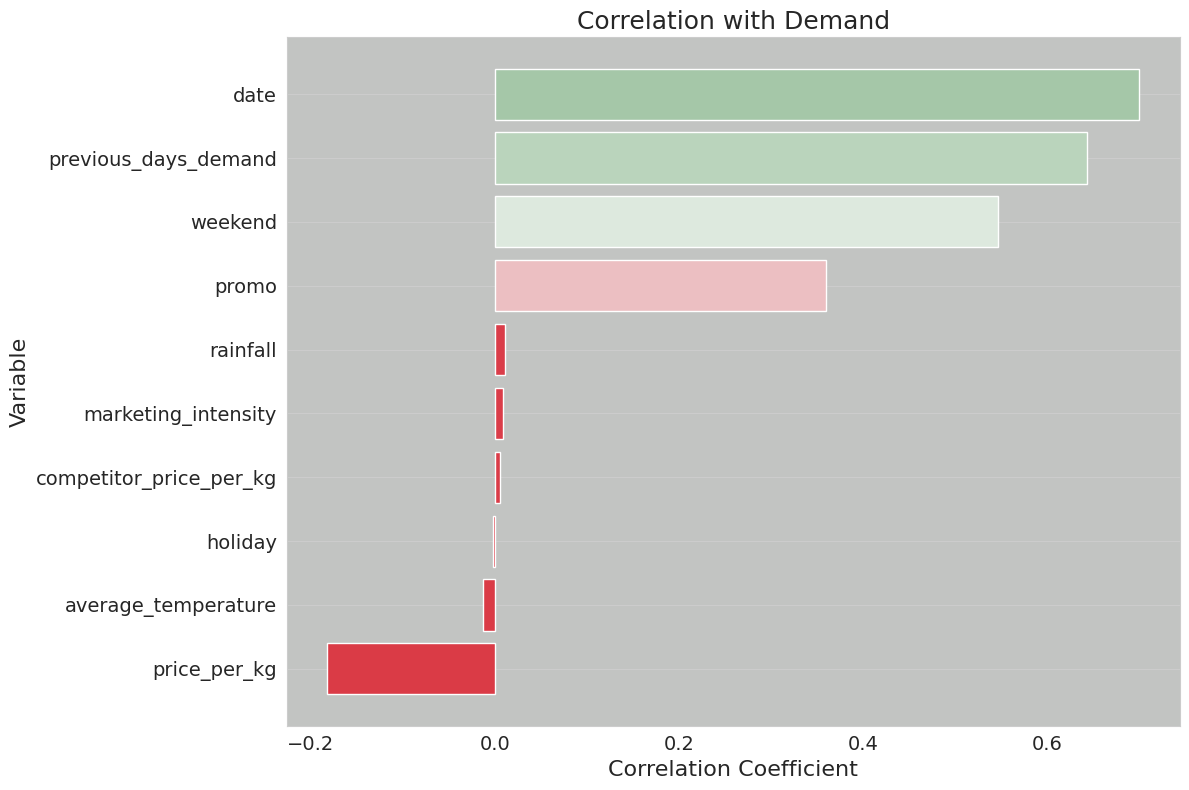

In [9]:
# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")
correlation_plot

### 残差プロット

In [10]:
def plot_residuals(model, dvalid, valid_y, save_path=None):
    """
    Plots the residuals of the model predictions against the true values.

    Args:
    - model: The trained XGBoost model.
    - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
    - valid_y (pd.Series): The true values for the validation set.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the residuals plot on a Jupyter window)
    """

    # Predict using the model
    preds = model.predict(dvalid)

    # Calculate residuals
    residuals = valid_y - preds

    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Show the plot
    plt.close(fig)

    return fig

## Feature Importance

In [11]:
def plot_feature_importance(model, booster):
    """
    Plots feature importance for an XGBoost model.

    Args:
    - model: A trained XGBoost model

    Returns:
    - fig: The matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model,
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)

    return fig

## MLflow実験の設定

In [12]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

### ハイパーパラメータチューニング実行用の実験を作成

In [14]:
experiment_id = get_or_create_experiment("Apples_Demand(Optuna)")
experiment_id

'525481175147802494'

### MLflowの設定とモデル学習のためのデータ前処理

In [15]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

## 学習

### ロギングコールバックの実装

In [16]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [17]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error

### パイプラインの統合

ハイパーパラメータチューニングのためのOptunaと実験トラッキングのためのMLflowを組み合わせます。

In [18]:
run_name = "first_attempt"

統合したパイプラインを実行することにより、学習と記録が実行される。

In [19]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 58210.72333475486
Trial 1 achieved value: 57462.26688006556 with  1.3025% improvement
Trial 9 achieved value: 57365.856518985245 with  0.1681% improvement
Trial 17 achieved value: 57306.53431261072 with  0.1035% improvement
Trial 21 achieved value: 57268.03407549683 with  0.0672% improvement
Trial 39 achieved value: 40854.529122371896 with  40.1755% improvement
Trial 40 achieved value: 39106.9887342825 with  4.4686% improvement
Trial 41 achieved value: 38293.241029700395 with  2.1250% improvement
Trial 47 achieved value: 38056.19064564407 with  0.6229% improvement
Trial 50 achieved value: 35446.49395668956 with  7.3624% improvement
Trial 51 achieved value: 35338.750896916565 with  0.3049% improvement
Trial 108 achieved value: 35051.5559299406 with  0.8194% improvement
Trial 115 achieved value: 34708.30746072281 with  0.9890% improvement
Trial 185 achieved value: 34631.50125192538 with  0.2218% improvement
Trial 400 achieved value: 34507.89018793064 with 

/home/user01/.local/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Web UIより、今回の実験の結果としてどのように保存されたかを確認する。  
特にOptunaのハイパーパラメータ探索のステップ単位で保存され、モデル自体は実験の最終的な結果として保存されていることが確認することができる。

In [20]:
model_uri

'mlflow-artifacts:/525481175147802494/d0fc4542ad4446d4a590185ab0ad81d4/artifacts/model'